# Capstone Project - Text Summarization 

# Prototype

## Contents
1. Data loading
2. Prototype
3. Prediction Dataframe
4. ROUGE
5. Performance comparison with different parameters

## 1. Data loading

In [1]:
from os import listdir
import pandas as pd
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk import pos_tag
import re
import string
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# paths to main files
ROOT_DIRECTORY ='../data/'
DATA_CLEANED_DIRECTORY = ROOT_DIRECTORY + 'cleaned/'
FILE_CORPUS = 'corpus_clean_dataframe_with_statistics.pkl'

In [3]:
corpus = pd.read_pickle(DATA_CLEANED_DIRECTORY + FILE_CORPUS)

In [4]:
corpus.sample()

,article,summary,article_char_count,article_word_count,article_sentence_count,summary_char_count,summary_word_count,summary_sentence_count
8581,The Federal Aviation Administration said Frida...,"Sources say Bieber and his father were ""extrem...",3050,503,23,280,43,4


## 2. Prototype

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

### How the summarization algorithm works
![](./prototype_chart.png)

The run_article_summary function gets three main inputs: 
- the article to summarize
- the parameters for counting words in sentences, which can be based on stems or lemmar, and the range of n-grams, which can be 1-gram (unique words) or 2-grams (pairs of sequencial words), 3-grams, etc
- threshold factor: a float number >= 1 to weight each sentence score against the average score of sentences. 

The main components are:
1. \_create_dictionary_table: create a frequency_table, counting the total n-grams in the article, based on stems or lemmas
2. sent_tokenizer: function from nltk library to tokenize sentences in a string, giving back a list of strings, each string a sentence
3. \_calculate_sentence_scores: based on the sentences lists and the frequency table, will score each sentence based on the frequency apperance of each sentence n-gram in the whole article. Returns a dictionary with the score for each sentence
4. \_calculate_average_score: find the average of sentences scores in the article. This will form a basic threshold to select to extract sentences from the article to form the summary
5. \_get_article_summary: Extract from the article only the sentences that have scores that are equal or greater than a threshold, which is the average score of sentences multiplied by a factor

In [6]:
PUNCTUATION = ['"', "'", '.', '...', '!', '?', '(', ')', '[', ']', '{', '}', '\\', '/', ':', ',', '...',
               '$', '#', '%', '*', '%', '$', '#', '@', '--', '-', '_', '+', '=', '^', "''", '""', '']


# utility funcitons()

def tokens_without_punctuation(text):
    '''
     Extract words from a piece of text, removing any punctuation
    :param text: text to be tokenized into words. Could be a text with several sentences or an unique sentence
    :return: list of words from text, without punctuation
    '''
    tokens = word_tokenize(text)
    no_punctuation = [x for x in tokens if not re.fullmatch('[' + string.punctuation + ']+', x)]
    return no_punctuation


def  sentence_tokenize(text):
     '''
     Correctly separates in unique sentence, sentences that are terminated by newline "/n"  but without punctuation
     :param text: a string with the text to have sentences separated
     :return: a list of strings, each one a sentence from text
     '''
     sentence_tokenized = list()
     for txt in text.split('\n'):
          sentence_tokenized += sent_tokenize(txt)
     return sentence_tokenized


def _create_list_of_tokens(words_lst, tokenizer):
     '''
     Given a list of words, returns a list of tokens that might be lemmas or stems, cleaned from stop words
     :param words_lst: list of words to be tokenized
     :param tokenizer: (string) can be 'lemma' or 'stem'
     :return: list of tokens (strings), cleaned from stop words
     '''
     stop_words = set(stopwords.words('english'))
     stop_words.update(PUNCTUATION)

     if tokenizer == 'lemma':
          token_maker = lambda word: WordNetLemmatizer().lemmatize(word).lower()
     else:
          token_maker = lambda word: PorterStemmer().stem(word).lower()
     token_lst = list()
     for word in words_lst:
          token = token_maker(word)
          if token not in stop_words:
               token_lst.append(token)
     return token_lst


def _create_list_of_ngrams(token_lst, n_gram):
     '''
     Given a list of tokens retuns a unique list consolidating from unigram up to the required n-grams
     :param token_lst: list of tokens that could be stems or lemmas
     :param n_gram:  (string) the highest n-gram type ordered (e.g.: '1-gram', '2-gram', '3-gram', etc)
     :return: consolidated cummulative list of all ranges n-gram, from the unigrams up to the required n-grams
     '''
     n_gram_lst = []
     n = int(n_gram[0])
     for i in range(1, n + 1):
          i_grams = ngrams(token_lst, i)
          n_gram_lst += [' '.join(grams) for grams in i_grams]
     return n_gram_lst


In [7]:
def _create_dictionary_table(text, tokenizer = 'stem', n_gram = '1-gram'):
  
    # words tokenized
    words_lst = tokens_without_punctuation(text)
    # list of tokens (stems or lemmas)
    token_lst = _create_list_of_tokens(words_lst, tokenizer)
    # list on n-grams according to the input, ranging from 1-gram up to the n_gram 
    n_gram_lst = _create_list_of_ngrams(token_lst, n_gram)
    # create dictionary to count the frequency of n-grams
    frequency_table = dict()
    for n_gram_item in n_gram_lst:  
          if n_gram_item in frequency_table:
              frequency_table[n_gram_item] += 1
          else:
              frequency_table[n_gram_item] = 1
    
    return frequency_table


def _calculate_sentence_scores(sentences, frequency_table, tokenizer = 'stem', n_gram = '1-gram') -> dict:   

    #algorithm for scoring a sentence by its n-grams
    sentence_weight = dict()
    

    for sentence in sentences:
        words_lst = tokens_without_punctuation(sentence)
        # list of tokens (stems or lemmas)
        token_lst = _create_list_of_tokens(words_lst, tokenizer)
        # list on n-grams according to the input, ranging from 1-gram up to the n_gram 
        n_gram_lst = _create_list_of_ngrams(token_lst, n_gram)
        sentence_n_gram_count_without_stop_words = 0
        for n_gram_item in n_gram_lst:
            
            if n_gram_item in frequency_table:
                sentence_n_gram_count_without_stop_words += 1
                if sentence in sentence_weight:
                    sentence_weight[sentence] += frequency_table[n_gram_item]
                else:
                    sentence_weight[sentence] = frequency_table[n_gram_item]
                    
        # take the average score of the sentence            
        # make sentences with only stop words to have zero score
        # also make sentences of single-character sentences of punctuation or special characters to have zero score       
        if sentence in sentence_weight and sentence_weight[sentence] > 0:
          sentence_weight[sentence] = sentence_weight[sentence] / sentence_n_gram_count_without_stop_words
        else:
          sentence_weight[sentence] = 0
    
    return sentence_weight
  
 

def _calculate_average_score(sentence_weight) -> int:
   
    #calculating the average score for the sentences
    sum_values = 0
    for entry in sentence_weight:
        sum_values += sentence_weight[entry]

    #getting sentence average value from source text
    average_score = (sum_values / len(sentence_weight))
    
    return average_score

def _get_article_summary(sentences, sentence_weight, threshold):
    sentence_counter = 0
    article_summary = ''

    for sentence in sentences:
        if sentence in sentence_weight and sentence_weight[sentence] >= (threshold):
            article_summary += " " + sentence
            sentence_counter += 1

    return article_summary

def run_article_summary(article, tokenizer = 'stem', n_gram = '1-gram', threshold_factor = 1):
    
    #creating a dictionary for the word frequency table
    frequency_table = _create_dictionary_table(article, tokenizer, n_gram)

    #tokenizing the sentences
    sentences = sentence_tokenize(article)

    #algorithm for scoring a sentence by its words
    sentence_scores = _calculate_sentence_scores(sentences, frequency_table, tokenizer, n_gram)

    #getting the threshold
    average_score = _calculate_average_score(sentence_scores)

    #producing the summary
    article_summary = _get_article_summary(sentences, sentence_scores, threshold_factor*average_score)

    return article_summary



In [8]:
def nice_print(article = None, reference_summary = None, hypothesis_summary = None, width  = 80):
  dedented_text = lambda text: textwrap.dedent(text).strip()
  if article:
    print('ARTICLE')
    print(textwrap.fill(dedented_text(article), width=width), '\n')
  if reference_summary:
    print('REFERENCE SUMMARY')
    print(textwrap.fill(dedented_text(reference_summary), width=width), '\n')
  if hypothesis_summary:
    print('HYPOTHESIS SUMMARY')
    print(textwrap.fill(dedented_text(hypothesis_summary), width=width), '\n')


In [9]:
#idx = corpus.sample(1).index

In [10]:
idx = 83838

In [11]:
article = corpus.loc[idx, 'article']
reference_summary = corpus.loc[idx, 'summary']
hypothesis_summary = run_article_summary(article, 
                                         tokenizer = 'stem', 
                                         n_gram = '1-gram', 
                                         threshold_factor = 1.2)
nice_print(article, reference_summary, hypothesis_summary)

ARTICLE
NASA engineers will repair small cracks found on the space shuttle Discovery's
external fuel tank -- a development that could further delay its launch. "The
X-rays showed four additional small cracks on three stringers on the opposite
side of the tank from Discovery, and managers elected to repair those cracks
..." NASA said in a statement. The work is expected to take two to three days.
Additional repairs may be needed, NASA said. The cracks on support beams called
"stringers" showed up during the latest round of image scans that NASA has been
conducting to determine when the shuttle can take off, the space agency said
Thursday. The earliest possible launch date is February 3, according to the
agency. Earlier cracks found in the foam covering the fuel tank have repeatedly
delayed the shuttle's final launch, originally scheduled for November 1.
Technicians repaired the cracks and reapplied foam insulation on aluminum
brackets on the tank in November. The foam cracked while the 

In [12]:
idx2 = corpus.sample(1).index[0]

In [13]:
article = corpus.loc[idx2, 'article']
reference_summary = corpus.loc[idx2, 'summary']
hypothesis_summary = run_article_summary(article, 
                                         tokenizer = 'stem', 
                                         n_gram = '1-gram', 
                                         threshold_factor = 1.2)
nice_print(article, reference_summary, hypothesis_summary)

ARTICLE
Arrest warrants have been issued for two Americans accused of stealing adult and
infant body parts from a museum inside a Thai hospital and trying to ship them
to Las Vegas. But the two men have already left Thailand despite being
interviewed by police. The Americans, Ryan Edward McPherson and Daniel Jamon
Tanner, told police they wanted to surprise their friends back home, Royal Thai
Police Deputy Commissioner Gen. Ruangsak Jritake said Monday. It's unclear
whether McPherson or Tanner have attorneys. So far, they have not able to be
reached for comment. A delivery company uncovered the macabre shipment. On
Saturday, a DHL office in Thailand's Pathum Thani province called police after
workers there were scanning shipments and discovered the body parts inside three
packages. The packages contained five acrylic plastic boxes, Ruangsak said. One
box contained an infant's head; another contained a baby's left foot, which was
sliced into three pieces, the police official said. The o

In [14]:
print(idx2)

46928


## 3. Prediction

In [16]:
def make_predictions(df, n_gram_lst, token_type_lst, threshold_factor_lst,
                     n_predictions, interval_to_print):


  t0 = time.time()
  sampling_interval = len(df) // n_predictions
  index = df.index[::sampling_interval][:n_predictions]
  data = df.loc[index, 'summary']
  predictions = pd.DataFrame( data = data.values , columns = ['reference'], index = index)
  for n_gram in n_gram_lst:
    for token_type in token_type_lst:
      for threshold_factor in threshold_factor_lst:
        predicted_column = n_gram + '_' + token_type + '_' + str(threshold_factor)
        print('Prediction colum: {}'.format(predicted_column))
        # function must be updated to include n_grams and token types  
        predictions.loc[index, predicted_column] = df.loc[index, 'article'].apply(run_article_summary,
                                                                            args =(token_type, 
                                                                                   n_gram, 
                                                                                   threshold_factor))
        print('Time taken {:.2f} minutes'.format((time.time() - t0)/60))
          
    
  print()
  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return predictions

In [17]:
n_gram_lst = ['1-gram', '2-gram', '3-gram']
token_type_lst = ['stem', 'lemma']
threshold_factor_lst = [1, 1.1, 1.2, 1.3, 1.4]
n_predictions = 1000
interval_to_print = 500
predictions_test = make_predictions(corpus, n_gram_lst, token_type_lst, threshold_factor_lst,
                     n_predictions, interval_to_print)

Prediction colum: 1-gram_stem_1
Time taken 3.27 minutes
Prediction colum: 1-gram_stem_1.1
Time taken 6.59 minutes
Prediction colum: 1-gram_stem_1.2
Time taken 9.81 minutes
Prediction colum: 1-gram_stem_1.3
Time taken 13.04 minutes
Prediction colum: 1-gram_stem_1.4
Time taken 16.25 minutes
Prediction colum: 1-gram_lemma_1
Time taken 18.06 minutes
Prediction colum: 1-gram_lemma_1.1
Time taken 19.67 minutes
Prediction colum: 1-gram_lemma_1.2
Time taken 21.25 minutes
Prediction colum: 1-gram_lemma_1.3
Time taken 22.84 minutes
Prediction colum: 1-gram_lemma_1.4
Time taken 24.46 minutes
Prediction colum: 2-gram_stem_1
Time taken 27.73 minutes
Prediction colum: 2-gram_stem_1.1
Time taken 30.77 minutes
Prediction colum: 2-gram_stem_1.2
Time taken 33.92 minutes
Prediction colum: 2-gram_stem_1.3
Time taken 37.02 minutes
Prediction colum: 2-gram_stem_1.4
Time taken 40.28 minutes
Prediction colum: 2-gram_lemma_1
Time taken 42.04 minutes
Prediction colum: 2-gram_lemma_1.1
Time taken 43.85 minutes
P

## 4. ROUGE

In [0]:
!pip install py-rouge

     |████████████████████████████████| 61kB 2.4MB/s 


### Rouge Metric
**Hypothesis:** the summary produced by the machine learning algorithm

**Reference:**  the summary produced by human, considered the golden standard

#### Metrics in Rouge

**Recall:**       $R = \frac{number \, of \, overlapping \, words}{total \, words \,  in \,  reference  \, summary}$

**Precision:**        $P = \frac{number\, of \, overlapping \, words}{total \, words\,  in \, hypothesis summary}$

**F1 score:**        $F1 = \frac{P*R}{ (1 - \alpha)*P\,  +\,  \alpha*R}$


In [0]:
# test rouge with very simple example
import rouge

evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = 1,
                           limit_length = True,
                           length_limit = 100,
                           length_limit_type = 'words',
                           alpha = 0.5, # Default F1_score
                           stemming=True)

hypothesis = 'the cat was found under the bed' 
reference = 'the cat was under the bed'

scores = evaluator.get_scores(hypothesis, reference)
print(scores) 
# Expected Recall = 1/1 = 1.0 Precision = 6/7 = 0.8571 and F1 = 0.8571/(0.5*0.8571 + 0.5) = 0.9231

{'rouge-1': {'f': 0.923076923076923, 'p': 0.8571428571428571, 'r': 1.0}}


In [0]:
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)][score_entry]

      return rouge_score

In [0]:
idxs = [83838, 33433]
scores = list()
for idx in idxs:
  reference = corpus.loc[idx, 'summary']
  article = corpus.loc[idx, 'article']
  hypothesis = run_article_summary(article, 
                                   tokenizer = 'stem', 
                                   n_gram = '1-gram', 
                                   threshold_factor = 1.2)
  
  rouge_score = rouge_scoring(hypothesis, reference, 
                           max_n = 2, 
                           alpha = 0.7, 
                           score = 'Recall')
  scores.append(rouge_score)
print(scores)
  

[0.30952380952380953, 0.3333333333333333]


In [0]:
rouge_score

{'rouge-1': {'f': 0.42857142857142855,
  'p': 0.34782608695652173,
  'r': 0.5581395348837209}}

In [0]:
def calculate_rouge(df, max_n = 1, alpha = 0.5, score = 'F1'):
  '''Calculates the rouge score metric defined in score
     
     Parameters:
     df: pandas dataframe with first column with the reference summary, and columns with hypothesis summaries
     max_n (int): N-grams for ROUGE-N if specify. Default:1
     alpha (float): used to compute f1 score: P*R/((1-a)*P + a*R). Default:0.5
     score (str): 'Recall', 'Precision', or 'F1'
     
     Returns:
     scores_df: dataframe with new columns with the calculated metric score for each hypothesis summary
  '''
  t0 = time.time()
  evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
  if score == 'F1':
    score_entry = 'f'
  elif score == 'Precision':
    score_entry = 'p'
  else:
    score == 'Recall'
    score_entry = 'r'
  scores_df = pd.DataFrame()
  for column in df.columns[1:]:
    score_column = column + '_' + score
    for idx in df.index:
      hypothesis = df.loc[idx, column]
      reference = df.loc[idx, 'reference']
      rouge_scores = evaluator.get_scores(hypothesis, reference)
      scores_df.loc[idx, score_column] = rouge_scores['rouge-' + str(max_n)][score_entry]

  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return scores_df

In [0]:
# Calculate for predictions predictons_test dataframe, which has only one hypothesis summary with 1-gram, using stemming, and
# threshold factor = 1
max_n = 1
alpha = 0.5 # Default F1_score
score = 'F1'
predictions_scores = calculate_rouge(predictions_test, max_n, alpha, score)

Total time to execute: 2.02 minutes


F1 average = 0.2066
F1 standard deviation = 0.0930


Text(0.5, 1.0, 'F1 score')

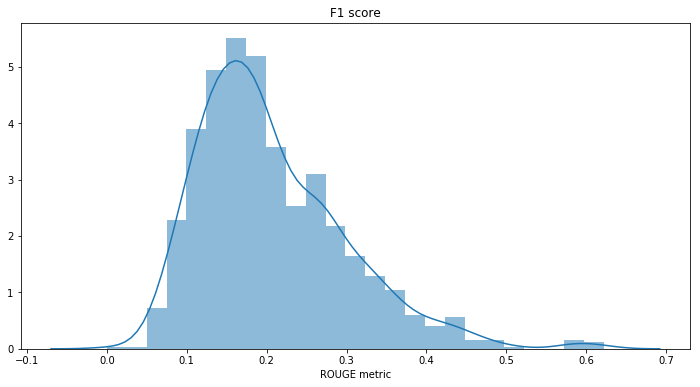

In [0]:
# Calculate the average and standard deviation of F1 scores for 1,000 summaries in predicions_test
# and plot the distribution of the F1-scores
score_column = '2-gram_stem_1_F1'
print('F1 average = {:.4f}'.format(predictions_scores[score_column].mean()))
print('F1 standard deviation = {:.4f}'.format(predictions_scores[score_column].std()))
_, ax = plt.subplots(figsize = (12,6))
sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)
ax.set_xlabel('ROUGE metric')
ax.set_title('F1 score')

## 5. Performance comparison with different parameters

In [0]:
def score_statistics(df):
  """print a prettytable of statistics for the rouge scores of summaries 
     
     Parameters:
     df: pandas dataframe with ROUGE scores, each columns with a different set of parameters
          
     Returns:
     printed table with the prediction type and the corresponding ROUGE score statistics
     (mean, standard deviation and % of zeros), mean and standard deviation are normalized 
     to base 100, i.e. are multiplied by 100
  
  """
  n_grams = list()
  token_types = list()
  thresholds = list()
  metrics = list()
  for column in df.columns:
    params = column.split('_')
    if params[0] not in n_grams:
        n_grams.append(params[0])
    if params[1] not in token_types:
        token_types.append(params[1])
    if params[2] not in thresholds:
        thresholds.append(params[2])
    if params[3] not in metrics:
        metrics.append(params[3])
    
  index =pd.MultiIndex.from_product([n_grams, token_types])
  statistic_names = ['Mean', 'Standard Deviation', '% of zeros']
  columns = pd.MultiIndex.from_product([statistic_names, thresholds])
  scores_statistics_df = pd.DataFrame(index = index, columns = columns)
  
  for score_column in df.columns:
    params = score_column.split('_')
    score_mean = round(df[score_column].mean()*100, 1)
    score_std = round(df[score_column].std()*100, 1)
    score_zeros = str(round((df.loc[df[score_column] == 0,
                                   score_column]
                             .count() / len(df))*100, 1)) +' %'
    scores_statistics_df.loc[(params[0], params[1]), ('Mean', params[2])] = score_mean
    scores_statistics_df.loc[(params[0], params[1]), ('Standard Deviation', params[2])] = score_std
    scores_statistics_df.loc[(params[0], params[1]), ('% of zeros', params[2])] = score_zeros

  return scores_statistics_df

In [0]:
def score_distributions(df, columns, bins = 10, ylim = (0,1)):
    """plot histogram and density curve of variables in columns in a datframe
     
     Parameters:
     df: pandas dataframe variables to plot
     columns: the specific columns to pot
     ylim: the range of tick values in the y-axis          
     Returns:
     plots of histogram and density curves
  
  """
    sns.set(color_codes=True)
    _, ax = plt.subplots(figsize = (12,6))
    for column in columns:
      sns.distplot(df[column], ax = ax, bins = bins, hist_kws={'alpha':0.5}, label = column)
    ax.set_xlabel('ROUGE metric')
    ax.set_ylim(ylim)
    ax.legend()

In [0]:
score_statistics(predictions_scores)

Mean                    ... % of zeros                       
                 1   1.1   1.2   1.3  ...        1.1    1.2     1.3     1.4
1-gram stem   20.2  22.6  23.7  23.2  ...      0.4 %  2.0 %   6.2 %  12.9 %
       lemma  20.3  22.6  23.3    23  ...      0.4 %  2.6 %   5.9 %  11.9 %
2-gram stem   20.7  23.2  23.3  21.5  ...      0.9 %  4.6 %  11.3 %  22.3 %
       lemma  20.7    23  23.3  21.5  ...      1.1 %  4.5 %  11.0 %  20.5 %
3-gram stem   21.1  23.5  22.6  19.5  ...      1.5 %  7.3 %  16.2 %  27.1 %
       lemma  21.3  23.2  22.4  19.5  ...      1.9 %  7.4 %  16.0 %  26.1 %

[6 rows x 15 columns]

We concluded that:
- low threshold, near 1.0, produces low scores
- if we increase the scores the proportion of zero summaries (summaries where no sentences were selected) increases, reducing the overall mean
- the maximum F1 score is at 23.7, when we using 1.2 as threshold, stems and unigrams

### Benchmarks of acadamic studies using the CNN dataset

Study | Date | Authors | F1 score 
 --- | --- | --- | --- 
 Abstractive Text Summarization using Sequence-to-sequence RNNs and Beyond | Aug/2016 | Ramesh Nallapati | 35.5
 Get To The Point: Summarization with Pointer-Generator Networks | Apr/2017 | Abigail See | 39 -40
 A Hierarchical Structured Self-Attentive Model for Extractive Document Summarization (HSSAS) | Apr/2018 | Kamal Al-Sabahi | 42
 Fine-tune BERT for Extractive Summarization | Mar/2019 | Yang Liu | 43

Our current results with the prototype are far away from the best in class models

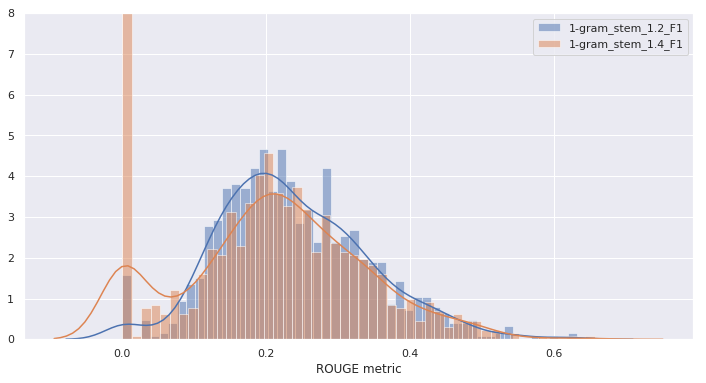

In [0]:
columns = ['1-gram_stem_1.2_F1','1-gram_stem_1.4_F1']
bins = 50
ylim = (0, 8)
score_distributions(predictions_scores, columns, bins, ylim )

In [0]:
def len_sent_tokenize(text):
  return len(sentence_tokenize(text))

In [0]:
# analysis of rouge scores per number of sentences in the hypothesis summary
qty_of_sentences = predictions_test['1-gram_stem_1.2'].apply(len_sent_tokenize)

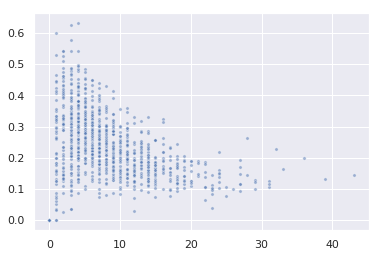

In [0]:
sns.scatterplot(x = qty_of_sentences.values, 
            y = predictions_scores['1-gram_stem_1.2_F1'].values,
            alpha =0.5, s = 12)

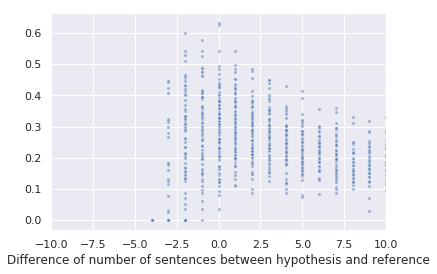

In [0]:
# analysis of rouge scores per  the difference of number of sentences in the hypothesis summary
# and number of sentenes in the reference summary
# let's zoom the plot around zero

qty_of_sentences_reference = predictions_test['reference'].apply(len_sent_tokenize)
diff_number_of_sentences = qty_of_sentences - qty_of_sentences_reference
sns.scatterplot(x = diff_number_of_sentences, 
            y = predictions_scores['1-gram_stem_1.2_F1'].values,
            alpha =0.5, s = 12)
plt.xlabel('Difference of number of sentences between hypothesis and reference')
plt.xlim((-10,+10))
plt.show()


The generated summaries are usually longer than the reference summary, and the higher the difference of length, the lower the ROUGE score.
Maybe our prototype model should try to predict the correct number of sentences in the generated summary.

In [0]:
# investigate very long summaries
idx = qty_of_sentences.idxmax()
article = corpus.loc[idx, 'article']
reference_summary = corpus.loc[idx, 'summary']
hypothesis_summary = predictions_test.loc[idx, '1-gram_stem_1.2']
nice_print(article, reference_summary, hypothesis_summary)
print('Lenght of generated summary: ', len_sent_tokenize(hypothesis_summary))

ARTICLE
Some are girlish 22-year-olds; others are women approaching 40. They come from
South Carolina's rural counties and its booming cities. They are loud and muted,
lively and vacant, hopeful and desperate. As different as they are, they share a
connection to two powerful forces : their addictions and their babies. They are
swallowed by the same shameful past. They don't know if they can be good
mothers. They don't know if they can be clean mothers. They're here at a state-
run drug-treatment program to learn how to do both. On this summer day, Ashley
Hendrix, 24, is eight months pregnant with her first child and one of 16 women
at the Phoenix Center's Serenity Place. This is her last shot to get clean -- or
face jail. South Carolina's state supreme court is alone in upholding the
prosecution of pregnant women for the damage drugs might do to their unborn
children. Across the country, local and state agencies have found ways to
prosecute pregnant women for drug use, but the cases ar

In [0]:
# investigate a sampled high score summary
idx = predictions_scores.loc[predictions_scores['1-gram_stem_1.2_F1'] > 0.5].sample(1).index[0]
article = corpus.loc[idx, 'article']
reference_summary = corpus.loc[idx, 'summary']
hypothesis_summary = predictions_test.loc[idx, '1-gram_stem_1.2']
nice_print(article, reference_summary, hypothesis_summary)
print('Lenght of generated summary: ', len_sent_tokenize(hypothesis_summary))
print('ROUGE score of generated summary: ', round(predictions_scores.loc[idx, '1-gram_stem_1.2_F1']*100, 1))

ARTICLE
SEATTLE, Washington   -- Software giant Microsoft apologized Wednesday for the
apparent bad judgment that led to the head of a black model being swapped for
that of a white model in an online advertisement. A black man in an online
Microsoft ad was replaced with a white man, bottom, on the company's Polish Web
site. The ad -- which showed three business people, one Asian, one white and one
black -- was altered on Microsoft's Web site for Poland to place the head of a
white man on a black man's body. "We apologized, fixed the error and we are
looking into how it happened," said Lou Gellos, a Microsoft spokesman. He said
that because the company was still reviewing how the swap occurred he could not
comment further. On Microsoft's official page on the social network site
Twitter, a posting calls the swap "a marketing mistake" and offers "sincere
apologies." The episode drew widespread criticism on the Internet after
Engadget, an influential tech blog, published news of the gaffe 

In [0]:
# investigate a sampled low score summary
idx = predictions_scores.loc[(predictions_scores['1-gram_stem_1.2_F1'] > 0.05) &
                               (predictions_scores['1-gram_stem_1.2_F1'] < 0.1)].sample(1).index[0]
article = corpus.loc[idx, 'article']
reference_summary = corpus.loc[idx, 'summary']
hypothesis_summary = predictions_test.loc[idx, '1-gram_stem_1.2']
nice_print(article, reference_summary, hypothesis_summary)
print('Lenght of generated summary: ', len_sent_tokenize(hypothesis_summary))
print('ROUGE score of generated summary: ', round(predictions_scores.loc[idx, '1-gram_stem_1.2_F1']*100, 1))

ARTICLE
Time has changed. In fact, most of the country just moved an hour forward. The
time change coincides with the conclusion of the 2014 Conservative Political
Action Conference, known as CPAC. The activists attending the conference are the
Republican Party's shock troops, but some Republican strategists don't want them
to shock mainstream voters this fall. Still, the gathering proved somewhat of a
litmus test for a schizophrenic conservative base trying to figure out where it
stands as the 2014 midterms approach, all the while struggling with change in a
country that is changing quite rapidly. It tells you something that one of the
biggest applause lines of CPAC wasn't even an applause line. It occurred when
Republican Senate Leader Mitch McConnell held a rifle on stage. (The rifle was
presented to Sen. Tom Coburn.) It also tells you something that New Jersey Gov.
Chris Christie was invited to CPAC this year, now that he is embroiled in the
Bridgegate scandal, but he was not invit